In [10]:
# Libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import scipy.fft as fft
import scipy.signal as signal
from sklearn.pipeline import Pipeline
from pprint import pprint
from datetime import datetime
from scipy.signal import find_peaks
import pywt
from scipy import stats
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit

# Project Outline
1. Explaining Dataset
2. Calibrate the data
3. Clean the data (and why we clean the data)
4. Plot the calibrate data
5. Statistical Description
6. PCA, why we do it and results
7. Check the PCA 
8. Discrete Fourier + Filter (normal + gaussian)
9. Wavelet + filter
10. Alternative Method
11. Results BPM from differents method + variability
12. What is the best method and why

# Preparing the data

In [30]:
filenames = ["Data/center_sternum.txt","Data/1_Stave_supine_static.txt","Data/2_Mattress_supine.txt","Data/3_Subject_sitting_chair.txt","Data/4_Chest_sweater.txt","Data/5_Under_chair.txt"]
chosen_file = 0
cuts = [(1129, 14306), (1750, 7999), (1659, 11078), (875, 6109), (1689, 5687), (834, 8756)]

In [31]:
def calibrate(data):
	offset_gyro = np.array([-2.242224, 2.963463, -0.718397])
	calibration_acc = np.array([[1.000966,     -0.002326418,-0.0006995499],
								[-0.002326379,  0.9787045,  -0.001540918],
								[-0.0006995811,-0.001540928, 1.00403]])
	offset_acc = np.array([-3.929942, -13.74679, 60.67546])
	calibration_magn = np.array([[0.9192851, -0.02325168, 0.003480837],
								[-0.02325175, 0.914876, 0.004257396],
								[0.003481006, 0.004257583, 0.8748001]])
	offset_magn = np.array([-95.67974, -244.9142, 17.71132])
	if filenames[chosen_file] != "../Data/center_sternum.txt":
		offset_gyro = np.array([-2.804399, 1.793105, 0.3411708])
		calibration_acc = np.array([[1.002982,    9.415505E-05, 0.004346743],
									[9.04459E-05, 1.002731,    -0.001444198],
									[0.004346536,-0.001444751,  1.030587]])
		offset_acc = np.array([3.602701, -20.96658, 54.97186])
		calibration_magn = np.array([[1.013437,    -0.04728858,  -0.001861475],
									[-0.04728862,  1.004832,    0.008222118],
									[-0.001861605, 0.008221965, 0.9439077]])
		offset_magn = np.array([-150.4098, 74.62431, 630.9805])
	# Apply calibration and offset to respective columns
	data[['GyroX', 'GyroY', 'GyroZ']] += offset_gyro
	data[['AccX', 'AccY', 'AccZ']] = np.dot(data[['AccX', 'AccY', 'AccZ']], calibration_acc.T) + offset_acc
	data[['MagnX', 'MagnY', 'MagnZ']] = np.dot(data[['MagnX', 'MagnY', 'MagnZ']], calibration_magn.T) + offset_magn
	return data

In [32]:
# Import the file inside "data" Dataframe
data = pd.read_csv(filenames[chosen_file], sep='\t').reset_index(drop=True)
data.head()

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193


In [33]:
data = calibrate(data)

In [34]:
# Cutting the start and the end of the dataset
cleaned_data = data[cuts[chosen_file][0]: cuts[chosen_file][1]].reset_index(drop=True)
cleaned_data.tail()

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
13172,5,200,1576222837,-37.444918,95.325839,-918.516572,-5.674628,5.243487,-0.941272,-343.645042,-345.016827,1030.876358,0.027717,0.588855,-0.805475,-0.060762
13173,5,200,1576222837,-34.471658,95.395469,-924.350188,-5.796765,5.197685,-1.017608,-343.645042,-345.016827,1030.876358,0.027129,0.588885,-0.805475,-0.060732
13174,5,200,1576222837,-40.774994,100.207411,-910.365650,-5.506689,5.457227,-0.971806,-342.631605,-345.064116,1030.874496,0.027724,0.588916,-0.805414,-0.060976
13175,5,200,1576222837,-39.175030,99.715138,-908.157748,-5.552491,5.762571,-1.139745,-342.631605,-345.064116,1030.874496,0.027626,0.588946,-0.805383,-0.061129
13176,5,200,1576222837,-27.375913,101.472574,-939.289954,-5.231880,6.067914,-1.384020,-343.641319,-345.033272,1028.988543,0.027930,0.588977,-0.805353,-0.061098


# Dimensionality Reduction
TODO: Write paragraph

In [41]:
## Pre-processing data: dropping columns and scaling
data_for_pca = cleaned_data.drop(columns=["Log Freq","Log Mode", "Time", "Timestamp"])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_pca)

KeyError: "['Time'] not found in axis"

In [ ]:
## Instantiating PCA
pca = PCA()

## Computing PCA
data_after_pca = pca.fit_transform(scaled_data)

In [ ]:
# Analyzing the result of PCA
PCA_Variances_Ratios = np.cumsum(pca.explained_variance_ratio_)

fig, ax1 = plt.subplots(1,1,figsize = (10,5))
ax1.scatter(np.arange(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_))
ax1.set_title("PCA Variances ratios")
ax1.set_ylabel("% of variance")
ax1.set_xlabel("Features number")
ax1.plot(np.arange(len(pca.explained_variance_ratio_)),np.ones(len(pca.explained_variance_ratio_))*0.9,color="red")
most_important_features_number = np.sum(np.cumsum(pca.explained_variance_ratio_) < 0.9)
print(f"PCA tell us to keep {most_important_features_number} features to retain 90% variance")

TODO: Explain results of PCA and pairplot

In [ ]:
# Pairplot to visualize the data
sns.pairplot(pd.DataFrame(data_after_pca[:,0:most_important_features_number]))

# Statistical Analysis
TODO: Write paragraph

# Discrete Fourier Transform

The Discrete Fourier Transform (DFT) converts a finite sequence sample of a function into a same-length sequence of equally-spaced samples of the discrete-time Fourier Transform (a complex-valued function of the frequency). The main relevant assumption is that the original function is equally spaced itself. 

$X_k = \sum_{n=0}^{N-1}x_n\cdot e^{-i2\pi \frac{k}{N}n}$

The Fast Fourier Transform (FFT) is a power algorithm to compute the DFT (and its inverse) that runs in $O(n \log n)$, providing a great computational advantage over the $O(n^2)$ of the naive implementation. 

We performed the FFT over all relevant pricipal components to investigate the frequency spectrum.

We can clearly see two peaks:
* First peak: around $0.2$ Hz (i.e. $12$ BPM), it refers to the respiratory rate. 
* Second peak: around $1.2$ Hz (i.e. $72$ BPM), it's related to the heart rate, our feature of interest. In an healthy adult at rest, the typical beat rate is between $40$ and $100$ BPM. 

We can also notice some high-frequency noise that could interfere with our analysis. 

In [ ]:
# Get the most relevant principal components
data_after_pca_only_most_important_feature = data_after_pca[:,0:most_important_features_number]
N = len(data_after_pca)

# Perform the DFT
sig_fft = fft.fftshift(fft.fft(data_after_pca_only_most_important_feature, axis=0))
frequencies = fft.fftshift(fft.fftfreq(N, d=1/mean_frequency))

In [ ]:
# Define the moving average (noise reduction)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

ax.axvspan(0.1, 0.3, color="lightblue", alpha=0.7, label="Breathing range")
ax.axvspan(1.1, 1.4, color="#F8D5D8", alpha=0.7, label="Heartbeat range")

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[1:-1], moving_average(np.abs(sig_fft[:, i]), 3), color=color, label="PC"+str(i+1))

ax.xaxis.set_ticks(np.arange(0, 10, 0.5))
ax.set_xlim(0, 5)
ax.set_ylim(-0.5, 3000)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Frequency spectrum (moving average)", fontsize=20)
ax.legend(fontsize=17, loc="upper right")

In [ ]:
# Plot relevant frequency band
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies, np.abs(sig_fft[:, i]), lw=2, color=color, label="PC"+str(i+1))

ax.set_xlim(1.0, 1.5)
ax.set_ylim(-0.5, 3000)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Heartbeat Frequency spectrum", fontsize=20)
ax.legend(fontsize=15)

# Filters
### Filter on the spectrum
To isolate the frequencies we are interesting in, we made a bandpass filter between $1.1$ and $1.4$ Hz. This means to filtered out most of the unwanted frequencies, but some noise is mantained. 

By antitrasforming the data, we can obtain a periodical time-series. Its frequency is an estimate of hearth rate itself. 

It is important to notice that the DTF integrate the temporal information, so it's a steady procedure and the temporal variabily of its inverse refers to the noisy spectrum. 

In [ ]:
# Filter the spectrum
filtered_sig_fft = sig_fft.copy()
filtered_sig_fft[(np.abs(frequencies) < 1.1) | (np.abs(frequencies) > 1.4)] = 0

# Antitrasformed the spectrum
inversed_sig_fft = np.fft.ifft(np.fft.ifftshift(filtered_sig_fft), axis=0)

In [ ]:
# Define the moving average (noise reduction)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[1:-1], moving_average(np.abs(filtered_sig_fft[:, i]), 3), color=color, label="PC"+str(i+1))

ax.set_xlim(-5, 5)
ax.set_ylim(-0.5, 1600)
ax.xaxis.set_ticks(np.arange(-5, 5, 0.5))
ax.vlines(0, -0.5, 1600, color="black")
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Frequency spectrum (moving average) after filter", fontsize=20)
ax.legend(fontsize=15)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(np.arange(len(inversed_sig_fft.real[:, i])), inversed_sig_fft.real[:, i], color=color, label="PC"+str(i+1))

ax.set_title("Antitrasformed principal components", fontsize=20)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncols = most_important_features_number, fontsize=15)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)

## Analyzing the peaks after passband filter

After having applied the Passband filter we apply the inverse fourier transform and then analyze the peaks to find the BPM.  We can use the data transformed with the PCA method.

### Gaussian Filter
As we said, the Fourier spectrum is noisy. One idea is to fit the data and to antitrasform the resulting function. Since we expect a single frequency, it would be reasonable to perform a Gaussian fit of the spectrum. 

The main limitation of this procedure is that the is that in that region of the spectrum there are only few points and the fitting procedure is unprecise. 

In [ ]:
from scipy.optimize import curve_fit
gauss = lambda x, A, mu, sigma : A**2/sigma/np.sqrt(2*np.pi)*np.exp(-0.5*((x-mu)/sigma)**2)

In [ ]:
# Fit the Gaussian functions
fits = [curve_fit(gauss, frequencies, filtered_sig_fft[:, i].real, p0=[12, 1.25, 0.03]) for i in range(most_important_features_number)]
print("Amplitude: " + str([fits[i][0][0] for i in range(most_important_features_number)]))
print("Peaks: " + str([fits[i][0][1] for i in range(most_important_features_number)]))
print("Standard deviations: " + str([fits[i][0][2] for i in range(most_important_features_number)]))

In [ ]:
# Plot relevant frequency band
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies, np.abs(filtered_sig_fft[:, i]), 3, color=color)

lin = np.linspace(1.1, 1.4, 1000)
for i, color in zip(pca_indeces, palette):
    ax.plot(lin, gauss(lin, fits[i][0][0], fits[i][0][1], fits[i][0][2]), lw=2, label="PCA " + str(i+1), color=color)

ax.legend(loc="upper right", fontsize=15)
ax.set_xlim(1.1, 1.4)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Gaussian fits of the frequency spectrum", fontsize=20)

In [ ]:
# Keep the gaussian referring to PCA 6
double_gauss = lambda x, A, mu, sigma: gauss(x, A, mu, sigma) + gauss(x, A, -mu, sigma)

param = fits[5][0]
gaussian_spectrum = double_gauss(frequencies, param[0], param[1], param[2])


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

ax.plot(frequencies, gaussian_spectrum, color=palette[5])

ax.set_xlim(-5, 5)
ax.set_ylim(-0.5, 2000)
ax.xaxis.set_ticks(np.arange(-5, 5, 0.5))
ax.vlines(0, -0.5, 2000, color="black")
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Gaussian spectrum (PCA 6)", fontsize=20)

### Peak Analysis
TODO

In [39]:
# Plot just as a reference
inversed_sig_fft = np.fft.ifft(np.fft.ifftshift(gaussian_spectrum), axis=0)
plt.plot(inversed_sig_fft.real)

NameError: name 'gaussian_spectrum' is not defined

#### Wavelet
A powerful alternative to the DFT is the *wavelet transform*, which overcomes the loss of the temporal information. 

In this project, we used a *Daubechies 6* wavelet. [The literature](https://www.sciencedirect.com/science/article/pii/S174680941930360X?via%3Dihub) suggests this wavelet because of its smooth shape and its similarity to the oscillating pattern of the heartbeat. 

The signal is iteratively divided into the low and high frequency components for $J$ levels. The net result is the list of coefficients $[A_J, \{D_j\}_j]$ with $1 \le j \le J$. Being $f_s$ the original frequency, $A_J$ refers to the frequencies between $0$ and $f_s/2^{J+1}$ while each $D_j$ coefficient refers to the $[f_s/2^{j+1}, f_s/2^{j}]$ range. Our ``get_frequency_ranges()`` function returns the ranges depending on $f_s$ and the used level.

The main limitation of this method is that you cannot choose the frequency range, because of the given discretization. 

We expect the normal beat to be between $[0.67, 1.67]$ Hz. Thus, the coefficient we need is the fifth (frequences between $[0.84, 1.70]$ Hz).


In [40]:
# Perform the multilevel decomposition of the time series
max_level = pywt.dwt_max_level(len(data_after_pca_only_most_important_feature), "db6")
print("Maximum useful level of decomposition for this dataset: " + str(max_level))

coeffs = pywt.wavedec(data_after_pca_only_most_important_feature, "db6", level=max_level, axis=0)

NameError: name 'data_after_pca_only_most_important_feature' is not defined

In [ ]:
# Helper function to compute the frequency ranges of a wavelet decomposition
def get_frequency_ranges(f_s, level):
    freq = [[0, f_s/2**(level+1)]]

    for j in range(level, 0, -1):
        freq.append([f_s/2**(j+1), f_s/2**(j)])

    return freq

get_frequency_ranges(mean_frequency, max_level)

We expect the normal beat to be between $[0.67, 1.67] Hz$. The coefficient we need is the fifth (frequences between $[0.78, 1.56]Hz$). We are cutting some boundary frequences.  

In [ ]:
# Function to set to zero the unwanted coefficients
def select_coeffs(coeffs, useful_coeffs):
    assert type([0, 1]) == list, "useful_coeffs must be a list"

    for i in range(len(coeffs)):
        if i not in useful_coeffs:
            #Replace with a zero array of the same size
            coeffs[i] = np.zeros_like(coeffs[i])
    
    return coeffs

filtered_coeff = select_coeffs(coeffs, [4])

In [ ]:
# Wavelet antitransform
filtered_sig = pywt.waverec(filtered_coeff, "db6", axis=0)

In [ ]:
# Plot the wavelet transform of the principal components
fig, ax = plt.subplots(figsize=(15, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(filtered_sig[:, i], color=color, label="PC"+str(i+1))

ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Wavelets", fontsize=20)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncols = most_important_features_number, fontsize=15)


#### PEAK ANALYSIS
TODO

# Alternative Method
## Data Composition

We also implemented another method to extrapolate the BPM from the data, using the fact that heart movement cause both a high linear and angular acceleration. We can see from the data that bot "Acc" and "Gyro" feature are composed of a low frequency component convoluted with a higher frequency component.
## Subtracting the Baseline
First we subtract the baseline low frequency component from a feature (here we use "GyroX" as an example, but we can use this method with all features).

KeyError: 'Time'

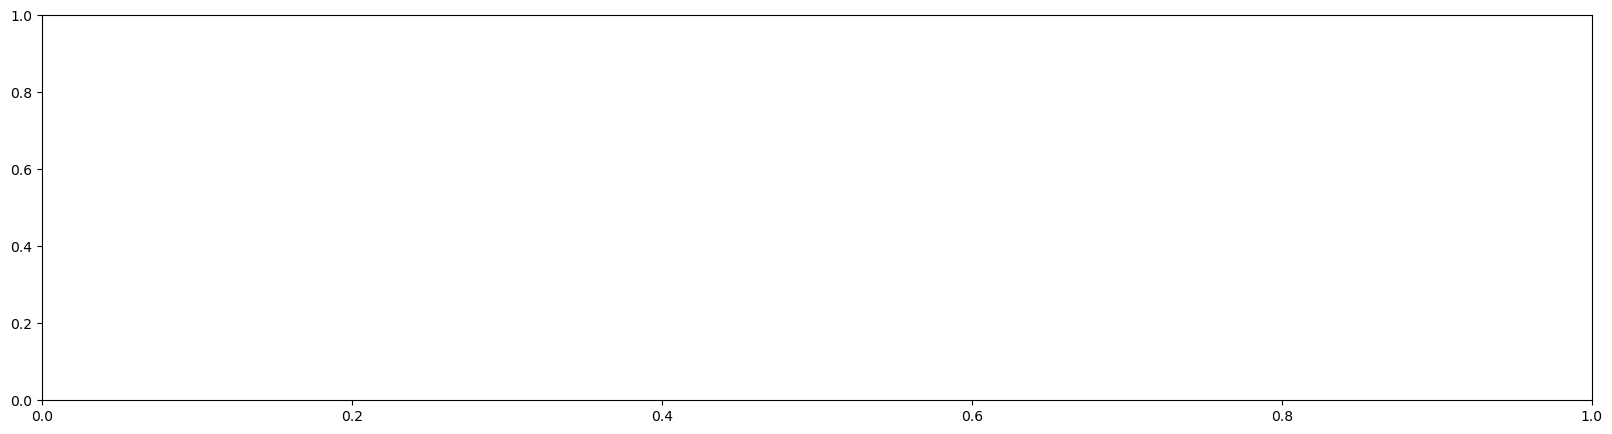

In [36]:
# Given that "cleaned_data" si the trucnated data

# Plot the data to showcase the low and high frequency component, using "GyroX" time-series as an example

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(cleaned_data["Time"].values, cleaned_data["GyroX"].values)
ax.set_title("GyroX in function of time")
ax.set_ylabel("GyroX")
ax.set_xlabel("Time")

# TODO: Fare due plot una con la baseline e una senza

## Finding the peaks
We can see that the data is characterized by a higher frequency component. We can analyze it's peaks to extrapolate the it's frequency.
First, we euristically determine a thresold to isolate the peaks, and take care to count only one peak per beat (heart beat has a two peak frequency), as seen in the plot above.
We can also, after having isolated the peaks, plot the histogram of the inverse periods (so the frequencies) of the individual peaks.

Estimated BPM from lower peaks:  77
Estimated BPM from higher peaks:  73
Estimated Mean BPM from peaks:  75
Mean BPM from histogram: 74.19, Standard Deviation: 4.72
Mean BPM from histogram: 74.9, Standard Deviation: 5.97
The HRV_max is: 17.185159826659916
The HRV_min is: 7.332162136906024


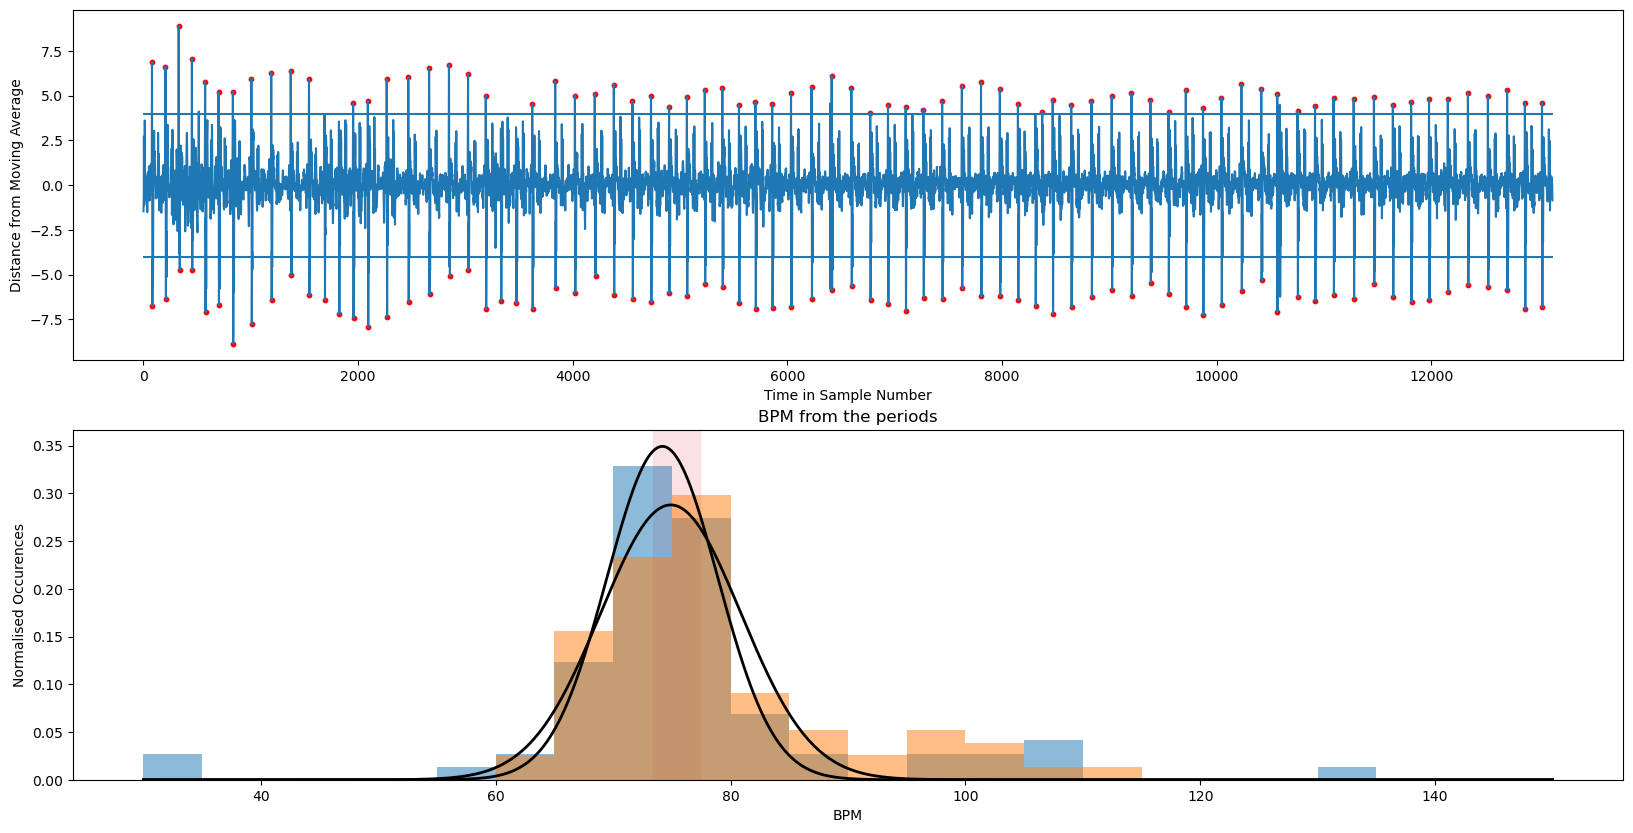

In [38]:
# Plot the peaks and the hsitogram of the frequency, and calculate the important values (for the main dataset)
PlotPeak_and_Histogram(cleaned_data["GyroX"],ht=4,lt=-4,plot=True,mean_frequency=217);

This method is useful in the way that is robust against noise and setup, but the threshold must be set according to the real-world setup and the physics involved in the data acquisition. The same amplitude cannot be shared among datasets as the maximum amplitude changes according to the position of the subject. After analyzing the dataset, a reasonable threshold can be set and the analysis subsequently performed.
As seen here, we can estimate a BPM of {BPM} from the "GyroX" feature, and a similar estimate (with different threshold) can be obtained.


## Results


# Helper Functions

In [28]:
# Helper Functions

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def Peaks(time_series,window=50,ht = 0.5, lt = -0.5,min_dis = 80,ax = False,plot=False,mean_frequency = 200):
    """Function to extrapolate the peaks from a time series, and optionally plot them"""
    
    time_series = time_series.values # Get only the numpy array
    moving_mean = running_mean(time_series,window) # Calculate moving average
    time_series = (time_series[int(window/2)-1:-int(window/2)] - moving_mean) # Subtract moving average from dataset
    minima_index, _ = signal.find_peaks(-time_series,-lt,distance=min_dis) # Find minima
    BPM_low = minima_index.shape[0]/(time_series.shape[0]/mean_frequency)*60 # Calculate mean BPM from minima
    maxima_index, _ = signal.find_peaks(time_series,ht,distance=min_dis) # Find maxima
    BPM_high = maxima_index.shape[0]/(time_series.shape[0]/mean_frequency)*60 # Calculate mean BPM from maxima
    
    if plot:
        if ax:
            pass
        else:
            fig, ax = plt.subplots(figsize=(20,5))
        ax.set_xlabel("Time in Sample Number")
        ax.set_ylabel("Distance from Moving Average")
        ax.plot(time_series)
        ax.hlines(lt,0,time_series.shape[0])
        ax.scatter(minima_index, time_series[minima_index],c = "red",s=10)
        ax.hlines(ht,0,time_series.shape[0])
        ax.scatter(maxima_index, time_series[maxima_index],c = "red",s=10)

    print("Estimated BPM from lower peaks: ", int(BPM_low))
    print("Estimated BPM from higher peaks: ", int(BPM_high))
    print("Estimated Mean BPM from peaks: ", int((BPM_low + BPM_high)/2))
    return (BPM_low, BPM_high)

def PeaksHist(time_series,window=50,ht = 0.5, lt = -0.5,min_dis = 80,ax = False,plot=False,moving_average=True,mean_frequency=217):

    gauss = lambda x, A, mu, sigma : A**2/sigma/np.sqrt(2*np.pi)*np.exp(-0.5*((x-mu)/sigma)**2)
    time_series = time_series.values
    if moving_average:
        moving_mean = running_mean(time_series,window)
        time_series = (time_series[int(window/2)-1:-int(window/2)] - moving_mean)    
    minima_index, _ = signal.find_peaks(-time_series,-lt,distance=min_dis)
    BPM_low = minima_index.shape[0]/(time_series.shape[0]/mean_frequency)*60
    maxima_index, _ = signal.find_peaks(time_series,ht,distance=min_dis)
    BPM_high = maxima_index.shape[0]/(time_series.shape[0]/mean_frequency)*60
    BPM_max = mean_frequency/np.array([maxima_index[i] - maxima_index[i-1] for i in range(1,len(maxima_index))])*60
    BPM_min = mean_frequency/np.array([minima_index[i] - minima_index[i-1] for i in range(1,len(minima_index))])*60
    bin_edges = np.arange(30,150,step=5)
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    h_max = np.histogram(BPM_max,bins=bin_edges)
    h_min = np.histogram(BPM_min,bins=bin_edges)
    
    popt_max, pcov_max = curve_fit(gauss,bin_center,h_max[0]/(np.sum(h_max[0])),p0=[1,75,12],maxfev=1000000)
    popt_min, pcov_min = curve_fit(gauss,bin_center,h_min[0]/(np.sum(h_min[0])),p0=[1,75,12],maxfev=1000000)

        
    print(f"Mean BPM from histogram: {round(popt_max[1],2)}, Standard Deviation: {round(popt_max[2],2)}")
    print(f"Mean BPM from histogram: {round(popt_min[1],2)}, Standard Deviation: {round(popt_min[2],2)}")
    hrv_max = np.sqrt(np.mean(np.diff(BPM_max)**2))
    hrv_min = np.sqrt(np.mean(np.diff(BPM_min)**2))
    print(f"The HRV_max is: {hrv_max}")
    print(f"The HRV_min is: {hrv_min}")
    
    if plot:
        if ax:
            pass
        else:
            fig, ax = plt.subplots(figsize=(20,5))
        
        width_max=h_max[1][1] - h_max[1][0]
        width_min=h_max[1][1] - h_max[1][0]
        ax.axvspan(BPM_low,BPM_high,color="#F8D5D8", alpha=0.7)
        ax.bar(h_max[1][0:-1],h_max[0]/(np.sum(h_max[0])),align="edge",width=width_max,alpha=0.5)
        ax.plot(np.linspace(30,150,num=120*40), gauss(np.linspace(30,150,num=120*40),*popt_max), 'k-', lw=2)
        ax.bar(h_min[1][0:-1],h_min[0]/(np.sum(h_min[0])),align="edge",width=width_min,alpha=0.5)
        ax.plot(np.linspace(30,150,num=120*40), gauss(np.linspace(30,150,num=120*40),*popt_min), 'k-', lw=2)
        ax.set_title("BPM from the periods")
        ax.set_xlabel("BPM")
        ax.set_ylabel("Normalised Occurences")
    return (popt_max,popt_min)
          
def PlotPeak_and_Histogram(time_series,window=50,ht = 0.5, lt = -0.5,min_dis = 80,ax = False,mean_frequency = 200,moving_average=True,plot=False):
    """ Function to plot the peaks and the resulting frequency histogram from the dataset"""
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(20,10))
    BPM_low, BPM_high = Peaks(time_series,window=window,ht=ht,lt=lt,min_dis=min_dis,ax = ax1,plot=True,mean_frequency = mean_frequency)
    popt_max,popt_min = PeaksHist(time_series,window=window,ht=ht,lt=lt,min_dis=min_dis,ax = ax2,plot=True,mean_frequency = mean_frequency)
    return (BPM_low, BPM_high, popt_max,popt_min)